

# Import Packages




In [0]:
#import initial packages for modeling
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Obtain the Data

In [0]:
#functions

#read in csv file
def load_csv_file(f):
  return pd.read_csv(f)

In [0]:
#import source files
coaches = load_csv_file("Coaches9.csv")
coach_record = load_csv_file("coach_win_percentage.csv")
power_index = load_csv_file("fsb_power_index_rank_2019.csv")
grad_rates = load_csv_file("grad_rates_with_abbr.csv")
team_lookup = load_csv_file("teams_lookup.csv")
stadiums = load_csv_file("stadiums.csv")
in_nfl = load_csv_file("in_the_nfl.csv")




# Scrub the Data

In [0]:
#functions
#quickly examine a dataframe's contents
def examine_df(df):
  print('\n Head:')
  print(df.tail(10).to_string())
  print('\n Tail:')
  print(df.head(10).to_string())
  print('\n Info:')
  print(df.info())
  print('\n Describe:')
  print(df.describe())
  print('Shape:')
  print(df.shape)
  print('\n Any Null:')
  print(df.isnull().any())
  print('\n Show Counts:')
  print(df.count())

#columns to lower
def set_lowercase_df(df):
     return df.columns.str.lower()

#remove special chars from numeric columns and set type to int
def scrub_numeric_cols(df,cols):
    for col in cols:
        df[col] = df[col].replace('[$,+]', '', regex=True)
        df[col] = df[col].replace('[--]', '0', regex=True)
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    return df


In [0]:
# coaches

#view data frames contents - commented out for readability
#examine_df(coaches)

# change column names to lowercase.
coaches.columns = set_lowercase_df(coaches)

# fix columns that should be numeric but include special characters or are not properly formatted.
cols = ["schoolpay","totalpay","bonus","bonuspaid"]
coaches = scrub_numeric_cols(coaches,cols)


In [0]:
#coach record

# change column names to lowercase.
coach_record.columns = set_lowercase_df(coach_record)

# examine_df(coach_record)


In [168]:

#power index

# change column names to lowercase.
power_index.columns = set_lowercase_df(power_index)

power_index = power_index.rename(columns={'team':'school'})
print(power_index.head(5).to_string())

# examine_df(coach_rank)

       school    conf   fpi  rank  efficiency
0   Air Force      MW   7.3     2        70.9
1       Akron     MAC -28.6     5         4.2
2     Alabama     SEC  29.4     1        92.7
3  Miami (FL)     ACC   5.4     3        54.2
4     Arizona  Pac-12  -2.4     4        41.5


In [169]:
#graduation rates

# change column names to lowercase.
grad_rates.columns = set_lowercase_df(grad_rates)

#select columns
cols = ["school_abbr","gsr","fgr"]
grad_rates2 = grad_rates[cols]

#rename columns
grad_rates2 = grad_rates2.rename(columns={'school_abbr':'school'})
grad_rates2.head()

#mean values when a school has multiple grad rates maybe because of different instances in the same city
#grad_rates2.dropna(inplace=True)
#grad_rates2 = grad_rates2.groupby(['school'])['gsr','fgr'].mean()

# examine_df(grad_rates)

,school,gsr,fgr
0,Akron,75.0,61.0
1,Alabama,85.0,65.0
2,Appalachian State,75.0,67.0
3,Arizona,75.0,60.0
4,Arizona State,76.0,58.0


In [170]:
#team column lookups
# change column names to lowercase.
team_lookup.columns = set_lowercase_df(team_lookup)
team_lookup = team_lookup.rename(columns={'team':'school'})
team_lookup.head()

# examine_df(team_lookup)

,school,nickname,city,state,conference,team_w_nickname
0,Air Force,Falcons,Colorado Springs,Colorado,Mountain West,Air Force Falcons
1,Akron,Zips,Akron,Ohio,MAC,Akron Zips
2,Alabama,Crimson Tide,Tuscaloosa,Alabama,SEC,Alabama Crimson Tide
3,Appalachian State,Mountaineers,Boone,North Carolina,Sun Belt,Appalachian State Mountaineers
4,Arizona,Wildcats,Tucson,Arizona,Pac-12,Arizona Wildcats


In [0]:
#stadium 
cols = ["team","capacity","stadium"]
stadiums_df = stadiums[cols]
stadiums_df = stadiums_df.rename(columns={'team':'school'})
stadiums_df = scrub_numeric_cols(stadiums_df,['capacity'])
stadiums_df.head()
# stadiums.drop(columns='school',axis=1)
stadiums_df.rename(columns={'school':'stdschool'},inplace=True)


# Merge the Data

In [0]:
# coach record
#merge coach record w/ team lookup
wins = pd.merge(coach_record,team_lookup, how="inner", left_on="school",right_on="team_w_nickname")
#subset wins
cols = ["school_y","head coach","first season","years_w_team","current_w","current_l","current_w_percentage","career_w","career_l","career_games","career_w_percentage"]
wins = wins[cols]

In [0]:
#merge datasets

#coachs with grad rates
coach_ds = pd.merge(coaches,grad_rates2, how="left", on="school")
#merge wins with coach w grad
coach_ds = pd.merge(coach_ds,wins,how="inner", left_on="school",right_on="school_y")
# merge power index
coach_ds = pd.merge(coach_ds,power_index, how="inner",on="school")
#coach_ds.head()
#merge stadium
coach_ds = pd.merge(coach_ds,stadiums_df,how="left",left_on="nnstadium",right_on="stdschool")
coach_ds.columns
#examine_df(coach_ds_all)
coach_ds = pd.merge(coach_ds,in_nfl,how="inner",on="school")
#subset 
cols = ['school', 'conference', 'coach', 'totalpay', 'gsr', 'fgr', 'years_w_team','current_w_percentage','career_games',
        'career_w_percentage', 'conf', 'fpi', 'rank', 'efficiency','capacity','in_nfl_cnt', 'stadium']
data = coach_ds[cols]
#print(data.head(150).to_string())

In [174]:
#clean up the data
#set the grad rates to the mean for null values
data['gsr'] = data['gsr'].fillna((data['gsr'].mean())).round()
data['fgr'] = data['fgr'].fillna((data['fgr'].mean())).round()
#drop rows with 0 set in totalpay
dropIndex = data[ data['totalpay'] == 0 ].index
data.drop(dropIndex , inplace=True)
dropIndex = data[ data['capacity'] == 0 ].index
data.drop(dropIndex , inplace=True)
dropIndex = data[ data['current_w_percentage'] == 0 ].index
data.drop(dropIndex , inplace=True)

data['experience'] = data['career_games'] / 12

#view all records - commented out for readability
#print(data.head(150).to_string())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_

In [175]:
print(data.describe().to_string)
print(str(data))

<bound method DataFrame.to_string of            totalpay         gsr  ...  in_nfl_cnt  experience
count  1.140000e+02  114.000000  ...  114.000000  114.000000
mean   2.507793e+06   80.271930  ...   11.359649    8.031433
std    1.916242e+06    7.759989  ...   10.170343    6.454414
min    4.000000e+05   54.000000  ...    1.000000    0.083333
25%    8.037155e+05   76.000000  ...    4.000000    3.166667
50%    2.000000e+06   79.000000  ...    9.000000    6.333333
75%    3.738494e+06   86.000000  ...   15.000000   11.437500
max    8.307000e+06  100.000000  ...   56.000000   31.583333

[8 rows x 13 columns]>
               school  ... experience
0           Air Force  ...  13.916667
2             Alabama  ...  25.666667
3                 UCF  ...   2.166667
6             Arizona  ...  12.750000
7       Arizona State  ...   2.166667
..                ...  ...        ...
136  Coastal Carolina  ...   2.000000
137     West Virginia  ...   5.250000
138  Georgia Southern  ...   2.666667
139       

# **Feature Engineering**
Set Rank and Conf features to categorical variables

In [176]:
#tranform rank and conference to categorical vars 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data.loc[:, 'rank'] = le.fit_transform(data['rank'])
data.loc[:, 'conf'] = le.fit_transform(data['conf'])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [177]:
#view stats on FPI scoring. Teams with higher FPI are considered "good" 
#and rank. The lower your score the weaker you are considered as an opponent
data.fpi.describe()

count    114.000000
mean       0.703509
std       13.061258
min      -35.800000
25%       -8.350000
50%       -0.150000
75%        7.800000
max       33.700000
Name: fpi, dtype: float64

In [178]:
#create conference strength feature. which sums up and potentially penalizes 
#teams that belong to a "weak" conference. The FPI value 
data["conference_strength"] = data.groupby('conference').fpi.transform('sum')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [179]:
#check average pay
pivot_table = pd.pivot_table(data, values = 'conference_strength', index = 'conference', aggfunc = np.mean).sort_values(by = 'conference_strength', ascending = False)
pivot_table['conference_strength'] = pivot_table['conference_strength'].map('{:,.2f}'.format)
pivot_table

,conference_strength
conference,
SEC,155.80
Big Ten,136.10
Big 12,58.60
Pac-12,58.10
ACC,56.40
Mt. West,-11.60
AAC,-15.30
Sun Belt,-77.90
Ind.,-86.40


The 5 teams with positive scores are known as the Power 5. These 5 conferences generally have more teams ranked in the top 20 every football season 

In [180]:
coaches.conference.value_counts()

C-USA       14
SEC         14
ACC         14
Big Ten     14
Mt. West    12
MAC         12
Pac-12      12
AAC         11
Sun Belt    10
Big 12      10
Ind.         6
Name: conference, dtype: int64

# Explore the Data

In [0]:
#functions
def plot_feature(df, col,target):
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean target var
        #in each category
        mean = df.groupby(col)[target].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.title('Distribution of {}'.format(col))
    plt.subplot(1, 2, 2)
    
    if df[col].dtype == 'int64' or col == 'id':
        #plot the mean totalpay for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)[target].mean()
        std = df.groupby(col)[target].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = target, data=df.sort_values(target))
    
    plt.xticks(rotation=45)
    plt.ylabel(target)
    plt.title('Relationship of {} with {}'.format(target,col))
    plt.show()

In [0]:
#Get a big picture look at the data
#examine_df(data)

In [183]:
#whats the final shape our data
data.shape

(114, 19)

In [184]:
#Look a the first 15 rows
print(data.head(15).to_string())

            school conference           coach  totalpay   gsr   fgr  years_w_team  current_w_percentage  career_games  career_w_percentage  conf   fpi  rank  efficiency  capacity  in_nfl_cnt                              stadium  experience  conference_strength
0        Air Force   Mt. West    Troy Calhoun    885000  80.0  63.0            13                 0.587           167                0.587     7   7.3     1        70.9   46692.0           2                       Falcon Stadium   13.916667                -11.6
2          Alabama        SEC      Nick Saban   8307000  85.0  65.0            13                 0.869           308                0.789     9  29.4     0        92.7  101821.0          56                 Bryant–Denny Stadium   25.666667                155.8
3              UCF        AAC     Josh Heupel   1700000  79.0  63.0             2                 0.846            26                0.846     1  12.6     1        77.4   45323.0          16        Bright House Networ

In [185]:
#check for missing values
data.isnull().sum()

school                  0
conference              0
coach                   0
totalpay                0
gsr                     0
fgr                     0
years_w_team            0
current_w_percentage    0
career_games            0
career_w_percentage     0
conf                    0
fpi                     0
rank                    0
efficiency              0
capacity                0
in_nfl_cnt              0
stadium                 0
experience              0
conference_strength     0
dtype: int64

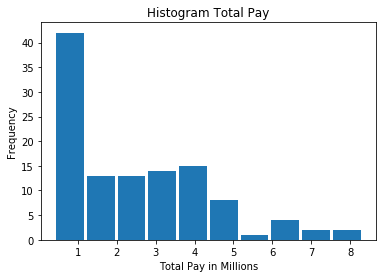

In [186]:
# Plot histogrm of total pay
plt.hist(data['totalpay']/1000000, density= False, stacked = False, rwidth = .9)
plt.title("Histogram Total Pay")
plt.xlabel('Total Pay in Millions')
plt.ylabel('Frequency')
plt.show()

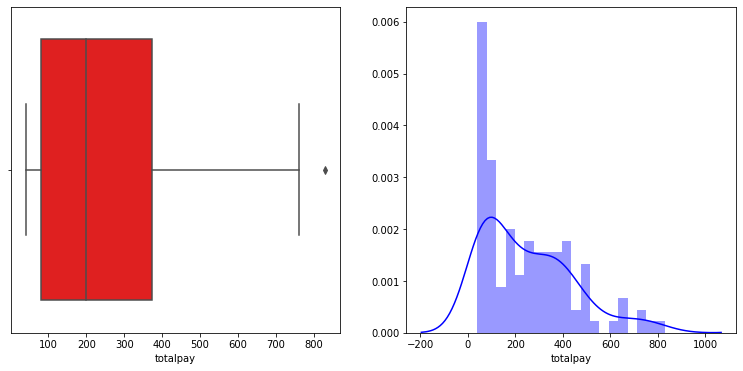

In [187]:
# Check the distribution of the target variable. 
plt.figure(figsize = (13, 6))
plt.subplot(1,2,1)
sns.boxplot(data.totalpay/10000,color = 'r')
plt.subplot(1,2,2)
sns.distplot(data.totalpay/10000, bins=20,color = 'b')
plt.show()

In [188]:
#check average pay per conference
pivot_table = pd.pivot_table(data, values = 'totalpay', index = 'conference', aggfunc = np.mean).sort_values(by = 'totalpay', ascending = False)
pivot_table['totalpay'] = pivot_table['totalpay'].map('${:,.2f}'.format)
pivot_table

,totalpay
conference,
SEC,"$5,355,837.90"
Big Ten,"$4,465,860.92"
Big 12,"$4,018,144.56"
ACC,"$3,255,698.65"
Pac-12,"$2,680,393.30"
AAC,"$1,620,334.62"
Mt. West,"$989,572.33"
Ind.,"$904,846.67"
C-USA,"$816,642.40"


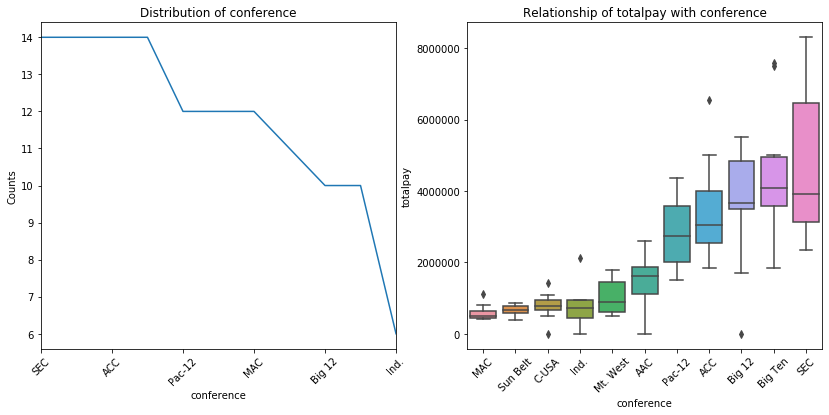

In [189]:
#compare total pay by conference. Again the "Power 5" tend to get paid very well
#compared to the other conference
plot_feature(coaches,'conference','totalpay')

**Relationship to Target Pay**
Lets look at the relationship of each feature to Target Pay. 

**Graduation Rate**

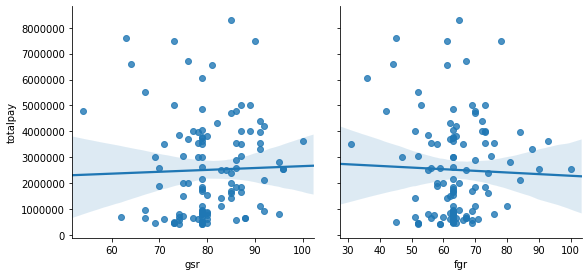

In [190]:
g = sns.PairGrid(data, x_vars=['gsr', 'fgr'], y_vars='totalpay',height=4)
g.map(sns.regplot)

Based upon the plot there does not appear to be a strong relationship between graduation rate and a head coach's pay. Not exactly surprising given the head coach's primary job is to win football games.

**Coaches Record:** 
It is appears there is a relationship between some of the features of within a coaches record and total pay. The two that jump out are current_w_percentage and career_w_percentage. Both account for the win percentages but from last season and over the course of a coaches career. Again this makes sense

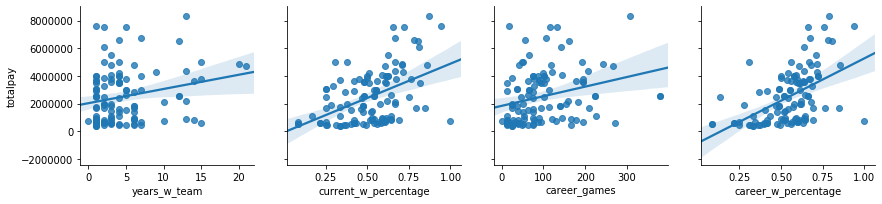

In [191]:
g = sns.PairGrid(data, x_vars=[ 'years_w_team', 'current_w_percentage', 'career_games','career_w_percentage'], y_vars='totalpay',height=3)
g.map(sns.regplot)

**Team Performance**
It also appears how the team performs has an effect on total pay for the coach. of particaular note. All 5 values here should be looked at in the modeling phase.

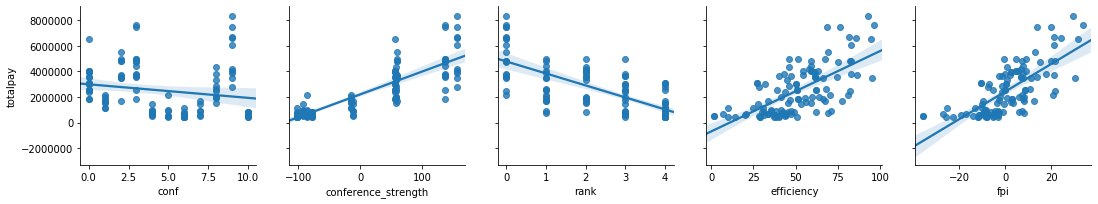

In [192]:
g = sns.PairGrid(data, x_vars=[ 'conf','conference_strength', 'rank', 'efficiency', 'fpi'], y_vars='totalpay',height=3)
g.map(sns.regplot)

**Stadium Size and NFL Players** 
Both Stadium and Number of currrent NFL players points towards both popularity of the school and the number of players that will go on to become even more popular within the NFL. It would stand to reason, if you are training and producing NFL calibre players, you will need to resources and a venue to showcase their talents. Plus you will be nicely compensated for this

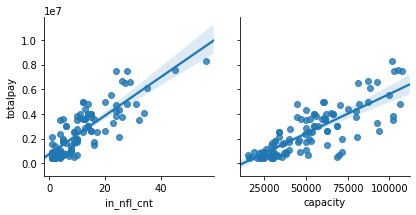

In [193]:
g = sns.PairGrid(data, x_vars=['in_nfl_cnt', 'capacity'], y_vars='totalpay',height=3 )
g.map(sns.regplot)


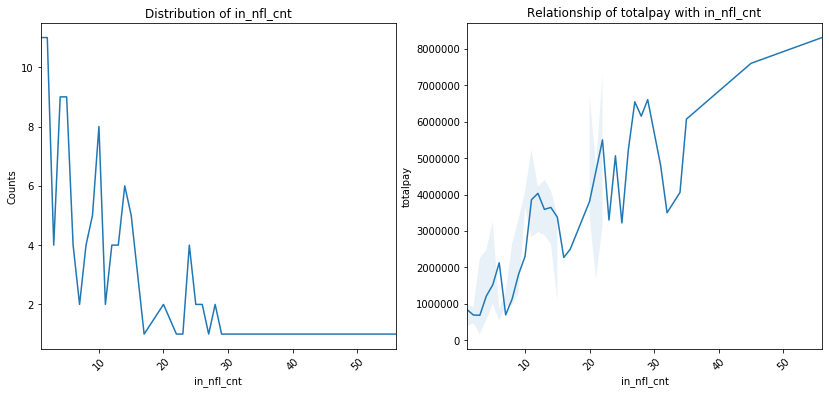

In [194]:
#The big takeawat here is those who get paid the best have a higher NFL player placement
plot_feature(data,'in_nfl_cnt','totalpay')

**Pick the Features for modeling**
based upon the above analysis we will pick the following features for modeling. Of these features, its safe to assume gsr and fgr are fairly weak predictors.

In [0]:
#select the columns
cols = ['school', 'conference', 'coach', 'totalpay', 'gsr', 'fgr', 'conference_strength',
       'years_w_team', 'current_w_percentage', 'career_games', 'in_nfl_cnt',
       'career_w_percentage', 'conf', 'rank', 'efficiency', 'fpi', 'capacity']

In [0]:
#create the dataset to be used for modeling
dataset = data[cols]

In [197]:
#look to make sure there are significant concerns
dataset.describe()

,totalpay,gsr,fgr,conference_strength,years_w_team,current_w_percentage,career_games,in_nfl_cnt,career_w_percentage,conf,rank,efficiency,fpi,capacity
count,1.140000e+02,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,2.507793e+06,80.271930,63.885965,16.969298,4.631579,0.519535,96.377193,11.359649,0.548781,4.552632,2.421053,51.008772,0.703509,51588.403509
std,1.916242e+06,7.759989,10.463386,89.038031,4.333984,0.183242,77.452971,10.170343,0.163945,3.371122,1.492724,20.544778,13.061258,24162.975818
min,4.000000e+05,54.000000,31.000000,-101.900000,0.000000,0.083000,1.000000,1.000000,0.083000,0.000000,0.000000,2.000000,-35.800000,15314.000000
25%,8.037155e+05,76.000000,59.250000,-77.900000,1.000000,0.406500,38.000000,4.000000,0.474000,2.000000,1.000000,37.750000,-8.350000,30662.500000
50%,2.000000e+06,79.000000,63.000000,56.400000,3.000000,0.532000,76.000000,9.000000,0.573500,4.000000,3.000000,50.000000,-0.150000,50000.000000
75%,3.738494e+06,86.000000,69.000000,58.600000,6.000000,0.624500,137.250000,15.000000,0.642000,8.000000,4.000000,62.925000,7.800000,66006.250000
max,8.307000e+06,100.000000,100.000000,155.800000,21.000000,1.000000,379.000000,56.000000,1.000000,10.000000,4.000000,96.600000,33.700000,107601.000000


nothing too concerning here. We do have a few coaches that are new to the team. So years_w_team is 0. Otherwise the data looks pretty good

In [198]:
#dedupe the dataset
dataset.drop_duplicates()
dataset.shape

(114, 17)

Looks like we lost a few teams after dropping the records where total pay was missing

In [199]:
dataset.isnull().sum()

school                  0
conference              0
coach                   0
totalpay                0
gsr                     0
fgr                     0
conference_strength     0
years_w_team            0
current_w_percentage    0
career_games            0
in_nfl_cnt              0
career_w_percentage     0
conf                    0
rank                    0
efficiency              0
fpi                     0
capacity                0
dtype: int64

In [200]:
print("HEAD")
print(dataset.head().to_string())
print("Tail")
print(dataset.tail().to_string())

HEAD
          school conference         coach  totalpay   gsr   fgr  conference_strength  years_w_team  current_w_percentage  career_games  in_nfl_cnt  career_w_percentage  conf  rank  efficiency   fpi  capacity
0      Air Force   Mt. West  Troy Calhoun    885000  80.0  63.0                -11.6            13                 0.587           167           2                0.587     7     1        70.9   7.3   46692.0
2        Alabama        SEC    Nick Saban   8307000  85.0  65.0                155.8            13                 0.869           308          56                0.789     9     0        92.7  29.4  101821.0
3            UCF        AAC   Josh Heupel   1700000  79.0  63.0                -15.3             2                 0.846            26          16                0.846     1     1        77.4  12.6   45323.0
6        Arizona     Pac-12  Kevin Sumlin   2000000  75.0  60.0                 58.1             2                 0.375           153           5                0

# Model

In [0]:
#import the modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [202]:
#code below from modified from live session live session
#simply splitting the data for training and testing
from scipy.stats import uniform  # for training-and-test split

# employ training-and-test regimen for model validation
np.random.seed(1234)
dataset['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(dataset))
coach_train = dataset[dataset['runiform'] >= 0.33]
coach_test = dataset[dataset['runiform'] < 0.33]
# check training data frame
print('\ncoach_train data frame (rows, columns): ',coach_train.shape)
print(coach_train.head())
# check test data frame
print('\ncoach_test data frame (rows, columns): ',coach_test.shape)
print(coach_test.head())


coach_train data frame (rows, columns):  (82, 18)
           school conference         coach  ...   fpi  capacity  runiform
2         Alabama        SEC    Nick Saban  ...  29.4  101821.0  0.622109
3             UCF        AAC   Josh Heupel  ...  12.6   45323.0  0.437728
6         Arizona     Pac-12  Kevin Sumlin  ...  -2.4   51811.0  0.785359
7   Arizona State     Pac-12  Herm Edwards  ...   6.0   71706.0  0.779976
11         Auburn        SEC   Gus Malzahn  ...  21.3   87451.0  0.801872

[5 rows x 18 columns]

coach_test data frame (rows, columns):  (32, 18)
            school conference               coach  ...   fpi  capacity  runiform
0        Air Force   Mt. West        Troy Calhoun  ...   7.3   46692.0  0.191519
9   Arkansas State   Sun Belt      Blake Anderson  ...  -6.1   30964.0  0.272593
10            Army       Ind.         Jeff Monken  ...  -4.6   38000.0  0.276464
24         Clemson        ACC        Dabo Swinney  ...  31.5   81500.0  0.013768
31   East Carolina        A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**Model 1**
We use Stats Model Linear Regression for the first model. We will include all features. 

In [203]:
# model includes all features 
model1 = str('totalpay ~  gsr +  fgr + years_w_team +  current_w_percentage +  career_games +\
                    in_nfl_cnt + career_w_percentage +  conf +  rank +  efficiency +  fpi +  capacity')

# fit the model to the training set
lm1 = smf.ols(model1, data = coach_train).fit()
# summary of model fit to the training set
print(lm1.summary())
# training set predictions from the model fit to the training set
coach_train['predict_totalpay'] = lm1.fittedvalues

# test set predictions from the model fit to the training set
coach_test['predict_totalpay'] = lm1.predict(coach_test)

                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     29.60
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.60e-22
Time:                        08:24:32   Log-Likelihood:                -1230.7
No. Observations:                  82   AIC:                             2487.
Df Residuals:                      69   BIC:                             2519.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             6.472e+06 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [204]:
# MODEL
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(coach_test['totalpay'].corr(coach_test['predict_totalpay']),2),3))

# use the full data set to obtain an estimate of the change in
# totalpayance based upon other features
lm1_fit = smf.ols(model1, data = dataset).fit()
print(lm1_fit.summary())

print('\nEstimated Effect of all features on Total Pay: ',\
    round(lm1_fit.params,0))



Proportion of Test Set Variance Accounted for:  0.769
                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     39.08
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.56e-32
Time:                        08:24:32   Log-Likelihood:                -1711.7
No. Observations:                 114   AIC:                             3449.
Df Residuals:                     101   BIC:                             3485.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Model 1 R-squared:  0.733087370945708
Model 1 RMSE:  885038.7862307295
Model 1 MAE:  697821.1531499845


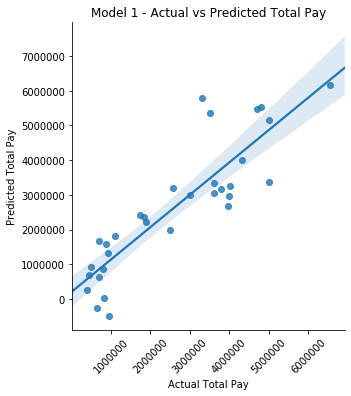

In [205]:
#Print Errors and Plot Results
print('Model 1 R-squared: ', r2_score(coach_test['totalpay'], 
                                      coach_test['predict_totalpay']))
print('Model 1 RMSE: ', np.sqrt(mean_squared_error(coach_test['totalpay'], 
                                                   coach_test['predict_totalpay'])))
print('Model 1 MAE: ', mean_absolute_error(coach_test['totalpay'], 
                                           coach_test['predict_totalpay']))

sns.lmplot(x='totalpay', y='predict_totalpay', data=coach_test)
_ = plt.title('Model 1 - Actual vs Predicted Total Pay')
_ = plt.xlabel('Actual Total Pay')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Predicted Total Pay')
plt.show()

In [206]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]

#Predicting salary for current position
pred_totalpay = lm1_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

Suggested Total Pay for Syracuse Head Coach is $2,371,579.32
Actual Total Pay $2,401,206.00


**Model 2**
This time - lets include only the stastically relevant features to see if we can improve the model

In [207]:
# model includes all features 
model2 = str('totalpay ~ in_nfl_cnt + conf +  rank +  efficiency +  fpi')
# fit the model to the training set
lm2 = smf.ols(model2, data = coach_train).fit()
# summary of model fit to the training set
print(lm2.summary())
# training set predictions from the model fit to the training set
coach_train['predict_totalpay'] = lm2.fittedvalues

# test set predictions from the model fit to the training set
coach_test['predict_totalpay'] = lm2.predict(coach_test)

                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     61.05
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           3.24e-25
Time:                        08:24:33   Log-Likelihood:                -1239.0
No. Observations:                  82   AIC:                             2490.
Df Residuals:                      76   BIC:                             2504.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.887e+06   1.74e+06      5.106      0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [208]:
# MODEL
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(coach_test['totalpay'].corr(coach_test['predict_totalpay']),2),3))

# use the full data set to obtain an estimate of the change in
# totalpayance based upon other features
lm2_fit = smf.ols(model2, data = dataset).fit()
print(lm2_fit.summary())

print('\nEstimated Effect of all features on Total Pay: ',\
    round(lm2_fit.params,0))


Proportion of Test Set Variance Accounted for:  0.771
                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     82.19
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           3.38e-35
Time:                        08:24:33   Log-Likelihood:                -1720.9
No. Observations:                 114   AIC:                             3454.
Df Residuals:                     108   BIC:                             3470.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Model 2 R-squared:  0.7512790359847417
Model 2 RMSE:  854346.291109091
Model 2 MAE:  690290.407867036


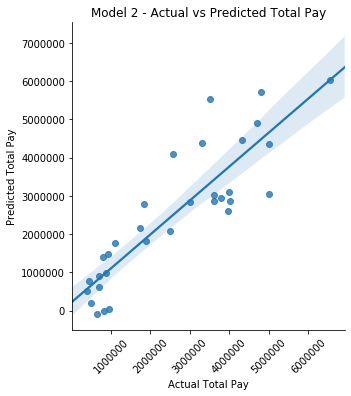

In [209]:
#Print Errors and Plot Results
print('Model 2 R-squared: ', r2_score(coach_test['totalpay'], 
                                      coach_test['predict_totalpay']))
print('Model 2 RMSE: ', np.sqrt(mean_squared_error(coach_test['totalpay'], 
                                                   coach_test['predict_totalpay'])))
print('Model 2 MAE: ', mean_absolute_error(coach_test['totalpay'], 
                                           coach_test['predict_totalpay']))

sns.lmplot(x='totalpay', y='predict_totalpay', data=coach_test)
_ = plt.title('Model 2 - Actual vs Predicted Total Pay')
_ = plt.xlabel('Actual Total Pay')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Predicted Total Pay')
plt.show()

In [210]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]

#Predicting salary for current position
pred_totalpay = lm2_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

Suggested Total Pay for Syracuse Head Coach is $2,228,332.09
Actual Total Pay $2,401,206.00


**Model 3**
Mixed linear model grouped by conference

In [211]:
# model includes all features 
model3 = str('totalpay ~ in_nfl_cnt +   rank +  efficiency + fpi + capacity')
# fit the model to the training set
mxlm = smf.mixedlm(model3, data = coach_train,groups="conference").fit()
# summary of model fit to the training set
print(mxlm.summary())
# training set predictions from the model fit to the training set
coach_train['predict_totalpay'] = mxlm.fittedvalues

# test set predictions from the model fit to the training set
coach_test['predict_totalpay'] = mxlm.predict(coach_test)

                     Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      totalpay         
No. Observations:        82           Method:                  REML             
No. Groups:              11           Scale:                   544074761609.7921
Min. group size:         3            Likelihood:              -1172.1955       
Max. group size:         14           Converged:               Yes              
Mean group size:         7.5                                                    
--------------------------------------------------------------------------------
                    Coef.         Std.Err.    z    P>|z|    [0.025      0.975]  
--------------------------------------------------------------------------------
Intercept           4545144.999 1673331.390  2.716 0.007 1265475.740 7824814.258
in_nfl_cnt            64497.595   16418.043  3.928 0.000   32318.821   96676.368
rank                -321960.482  173438.968 -1.856

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [212]:
# MODEL
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(coach_test['totalpay'].corr(coach_test['predict_totalpay']),2),3))

# use the full data set to obtain an estimate of the change in
# totalpayance based upon other features
mxlm_fit = smf.mixedlm(model3, data = data,groups="conference").fit()
print(mxlm_fit.summary())

print('\nEstimated Effect of all features on Total Pay: ',\
    round(mxlm_fit.params,0))


Proportion of Test Set Variance Accounted for:  0.735
                     Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      totalpay         
No. Observations:        114          Method:                  REML             
No. Groups:              11           Scale:                   542935670868.2556
Min. group size:         6            Likelihood:              -1652.4997       
Max. group size:         20           Converged:               Yes              
Mean group size:         10.4                                                   
--------------------------------------------------------------------------------
                    Coef.         Std.Err.    z    P>|z|    [0.025      0.975]  
--------------------------------------------------------------------------------
Intercept           4059592.628 1378411.564  2.945 0.003 1357955.606 6761229.650
in_nfl_cnt            69802.539   14021.544  4.978 0.000   42320.817   97284

Model 3 R-squared:  0.7052233570397024
Model 3 RMSE:  930088.5041794796
Model 3 MAE:  774661.5131787339


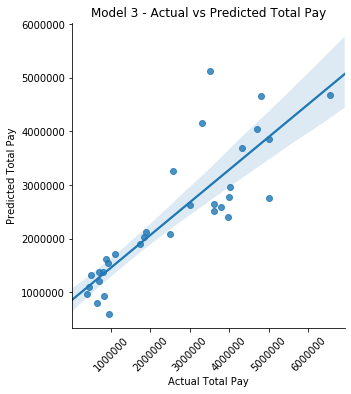

In [213]:
#Print Errors and Plot Results
print('Model 3 R-squared: ', r2_score(coach_test['totalpay'], 
                                      coach_test['predict_totalpay']))
print('Model 3 RMSE: ', np.sqrt(mean_squared_error(coach_test['totalpay'], 
                                                   coach_test['predict_totalpay'])))
print('Model 3 MAE: ', mean_absolute_error(coach_test['totalpay'], 
                                           coach_test['predict_totalpay']))

sns.lmplot(x='totalpay', y='predict_totalpay', data=coach_test)
_ = plt.title('Model 3 - Actual vs Predicted Total Pay')
_ = plt.xlabel('Actual Total Pay')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Predicted Total Pay')
plt.show()

In [214]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]

#Predicting salary for current position
pred_totalpay = mxlm_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

Suggested Total Pay for Syracuse Head Coach is $1,889,962.68
Actual Total Pay $2,401,206.00


**Model 4**
Quantile Regression

In [240]:
# model includes all features 
model4 = str('totalpay ~ in_nfl_cnt + conf +  rank +  efficiency +  fpi')
# fit the model to the training set
qrlm = smf.quantreg(model4, data = coach_train).fit(q=.5)
# summary of model fit to the training set
print(qrlm.summary())
# training set predictions from the model fit to the training set
coach_train['predict_totalpay'] = qrlm.fittedvalues

# test set predictions from the model fit to the training set
coach_test['predict_totalpay'] = qrlm.predict(coach_test)

                         QuantReg Regression Results                          
Dep. Variable:               totalpay   Pseudo R-squared:               0.5457
Model:                       QuantReg   Bandwidth:                   8.117e+05
Method:                 Least Squares   Sparsity:                    2.105e+06
Date:                Sun, 26 Jan 2020   No. Observations:                   82
Time:                        08:36:04   Df Residuals:                       77
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.875e+06   1.24e+06      2.322      0.023     4.1e+05    5.34e+06
in_nfl_cnt  1.165e+05   1.57e+04      7.405      0.000    8.52e+04    1.48e+05
conf         -1.3e+05   3.52e+04     -3.687      0.000      -2e+05   -5.98e+04
rank        -4.75e+05   2.02e+05     -2.353      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [241]:
# MODEL
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(coach_test['totalpay'].corr(coach_test['predict_totalpay']),2),3))

# use the full data set to obtain an estimate of the change in
# totalpayance based upon other features
qrlm_fit = smf.quantreg(model4, data = dataset).fit(q=.5)
print(qrlm_fit.summary())

print('\nEstimated Effect of all features on Total Pay: ',\
    round(qrlm_fit.params,0))


Proportion of Test Set Variance Accounted for:  0.767
                         QuantReg Regression Results                          
Dep. Variable:               totalpay   Pseudo R-squared:               0.5445
Model:                       QuantReg   Bandwidth:                   7.680e+05
Method:                 Least Squares   Sparsity:                    2.161e+06
Date:                Sun, 26 Jan 2020   No. Observations:                  114
Time:                        08:36:08   Df Residuals:                      109
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.209e+06   1.02e+06      2.164      0.033    1.86e+05    4.23e+06
in_nfl_cnt  1.225e+05   1.44e+04      8.516      0.000     9.4e+04    1.51e+05
conf       -1.261e+05   3.02e+04     -4.171      0.000   -1.86e+05   -6.62e+

Model 4 R-squared:  0.730257950952954
Model 4 RMSE:  889717.3678647808
Model 4 MAE:  737894.6294061621


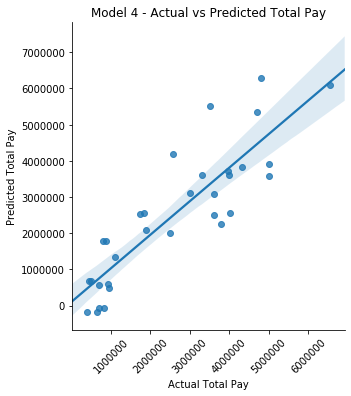

In [242]:
#Print Errors and Plot Results
print('Model 4 R-squared: ', r2_score(coach_test['totalpay'], 
                                      coach_test['predict_totalpay']))
print('Model 4 RMSE: ', np.sqrt(mean_squared_error(coach_test['totalpay'], 
                                                   coach_test['predict_totalpay'])))
print('Model 4 MAE: ', mean_absolute_error(coach_test['totalpay'], 
                                           coach_test['predict_totalpay']))

sns.lmplot(x='totalpay', y='predict_totalpay', data=coach_test)
_ = plt.title('Model 4 - Actual vs Predicted Total Pay')
_ = plt.xlabel('Actual Total Pay')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Predicted Total Pay')
plt.show()

In [243]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]

#Predicting salary for current position
pred_totalpay = qrlm_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

Suggested Total Pay for Syracuse Head Coach is $1,898,702.78
Actual Total Pay $2,401,206.00


**Syracuse switching to BIG 10 school**

In [244]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]
syracuse.conference = "Big Ten"
#syracuse.in_nfl_cnt = 100
#syracuse.fpi = 15

print(syracuse)

#Predicting salary for current position
pred_totalpay = lm2_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

       school conference        coach  ...  fpi  capacity  runiform
111  Syracuse    Big Ten  Dino Babers  ... -1.6   49250.0  0.746063

[1 rows x 18 columns]
Suggested Total Pay for Syracuse Head Coach is $2,228,332.09
Actual Total Pay $2,401,206.00


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


**Removing Conference from the model**

In [229]:
# model includes all features 
model5 = str('totalpay ~ in_nfl_cnt +   rank +  efficiency +  fpi')
# fit the model to the training set
lm5 = smf.quantreg(model5, data = coach_train).fit()
# summary of model fit to the training set
print(lm5.summary())
# training set predictions from the model fit to the training set
coach_train['predict_totalpay'] = lm5.fittedvalues

# test set predictions from the model fit to the training set
coach_test['predict_totalpay'] = lm5.predict(coach_test)

                         QuantReg Regression Results                          
Dep. Variable:               totalpay   Pseudo R-squared:               0.5346
Model:                       QuantReg   Bandwidth:                   1.116e+06
Method:                 Least Squares   Sparsity:                    2.620e+06
Date:                Sun, 26 Jan 2020   No. Observations:                   82
Time:                        08:31:59   Df Residuals:                       77
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.582e+06   2.49e+06      3.855      0.000    4.63e+06    1.45e+07
in_nfl_cnt  8.708e+04   2.19e+04      3.983      0.000    4.35e+04    1.31e+05
rank       -6.819e+05   2.51e+05     -2.716      0.008   -1.18e+06   -1.82e+05
efficiency  -1.29e+05    4.2e+04     -3.073      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [230]:
# MODEL
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(coach_test['totalpay'].corr(coach_test['predict_totalpay']),2),3))

# use the full data set to obtain an estimate of the change in
# totalpayance based upon other features
lm5_fit = smf.ols(model5, data = dataset).fit()
print(lm5_fit.summary())

print('\nEstimated Effect of all features on Total Pay: ',\
    round(lm5_fit.params,0))


Proportion of Test Set Variance Accounted for:  0.726
                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     90.61
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           9.35e-34
Time:                        08:32:07   Log-Likelihood:                -1726.9
No. Observations:                 114   AIC:                             3464.
Df Residuals:                     109   BIC:                             3477.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [231]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]

#Predicting salary for current position
pred_totalpay = lm5_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

Suggested Total Pay for Syracuse Head Coach is $1,855,957.63
Actual Total Pay $2,401,206.00


**Big East**

In [0]:
#Create a list of big east schools only
big_east_list = ['Cincinnati','UConn','Louisville','Pittsburgh','Rutgers','South Florida','Boston College']

In [233]:
#create a new dataset, training and test set
big_east_dataset = dataset[dataset["school"].isin(big_east_list)]
big_east_dataset.conference = 'Big East'
big_east_dataset.conf = 1

#training
big_east_coach_train = coach_train[coach_train["school"].isin(big_east_list)]
big_east_coach_train.conference = 'Big East'
big_east_coach_train.conf = 1

#test
big_east_coach_test = coach_test[coach_test["school"].isin(big_east_list)]
big_east_coach_test.conference = 'Big East'
big_east_coach_test.conf = 1


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [234]:
# model includes all features 
model6 = str('totalpay ~ in_nfl_cnt +  rank + conf +  efficiency +  fpi')
# fit the model to the training set
big_east_model = smf.ols(model6, data = big_east_coach_train).fit()
# summary of model fit to the training set
print(big_east_model.summary())
# training set predictions from the model fit to the training set
big_east_coach_train['predict_totalpay'] = big_east_model.fittedvalues

# test set predictions from the model fit to the training set
big_east_coach_test['predict_totalpay'] = big_east_model.predict(big_east_coach_test)

                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sun, 26 Jan 2020   Prob (F-statistic):                nan
Time:                        08:32:27   Log-Likelihood:                 66.042
No. Observations:                   4   AIC:                            -124.1
Df Residuals:                       0   BIC:                            -126.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.527e+05        inf         -0        n

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.6/dist-packa

In [238]:
# MODEL
# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(big_east_coach_test['totalpay'].corr(big_east_coach_test['predict_totalpay']),2),3))

# use the full data set to obtain an estimate of the change in
# totalpayance based upon other features
big_east_model_fit = smf.ols(model6, data = dataset).fit()
print(big_east_model_fit.summary())

print('\nEstimated Effect of all features on Total Pay: ',\
    round(big_east_model_fit.params,0))


Proportion of Test Set Variance Accounted for:  1.0
                            OLS Regression Results                            
Dep. Variable:               totalpay   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     82.19
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           3.38e-35
Time:                        08:34:27   Log-Likelihood:                -1720.9
No. Observations:                 114   AIC:                             3454.
Df Residuals:                     108   BIC:                             3470.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [239]:
#indexing syracuse
syracuse = dataset.loc[dataset.school == "Syracuse"]
syracuse.conference = 'Big East'

print(syracuse)

#Predicting salary for current position
pred_totalpay = big_east_model_fit.predict(syracuse)
#resetting the index
pred_totalpay = pred_totalpay.reset_index()
#printing the suggested vs. actual salary
print("Suggested Total Pay for Syracuse Head Coach is \
${:,.2f}\nActual Total Pay ${:,.2f}".format(float(pred_totalpay[0]), float(syracuse.totalpay.values[0])))

       school conference        coach  ...  fpi  capacity  runiform
111  Syracuse   Big East  Dino Babers  ... -1.6   49250.0  0.746063

[1 rows x 18 columns]
Suggested Total Pay for Syracuse Head Coach is $2,228,332.09
Actual Total Pay $2,401,206.00


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
